# Uploading to drive

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !kaggle datasets download -d tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !cp -avr /content/covid19-radiography-database.zip /content/drive/MyDrive/Covid\ Detection

'/content/covid19-radiography-database.zip' -> '/content/drive/MyDrive/Covid Detection/covid19-radiography-database.zip'


# downloading data set

In [1]:
!gdown --id 1cGPizHjHJxU8TnqfOniN6MwTt1XgTosL

Downloading...
From: https://drive.google.com/uc?id=1cGPizHjHJxU8TnqfOniN6MwTt1XgTosL
To: /content/covid19-radiography-database.zip
781MB [00:04, 181MB/s]


In [2]:
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [3]:
!rm -rf /content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
!rm -rf /content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
!rm -rf /content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
!rm -rf /content/COVID-19_Radiography_Dataset/README.md.txt
!rm -rf /content/COVID-19_Radiography_Dataset/Viral\ Pneumonia.metadata.xlsx

# Library

In [19]:
import torch
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time


# **Dataset** and data Loader 

In [5]:
dataset_folder = '/content/COVID-19_Radiography_Dataset'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root = dataset_folder, transform = transform)

In [6]:
dataset.class_to_idx

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [7]:
classes = dataset.classes
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Split pytorch **dataset**

In [8]:
split_ratio = 0.75 
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*split_ratio), len(dataset)- int(len(dataset)*split_ratio)])

In [9]:
batch = 4

In [10]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = batch, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_set, batch_size = batch, shuffle=True, num_workers=2)

# Vizuals

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

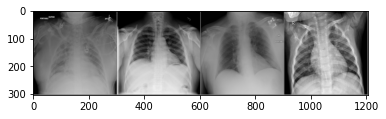

Lung_Opacity Normal Normal Normal


In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

# Model

In [24]:
model = torchvision.models.resnet152(pretrained= True)
model.fc = nn.Linear(2048 , len(classes))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
step = 0
loss_train = []
loss_val = []

#import the model

model = model.to(device)
model = model.train()

min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [29]:
file = open('logs_test4_epoch100_with_max_pool.txt', 'w')

print('training started.............................................')
file.write('training started.............................................\n')
start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    #file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / 2000))
            #log_loss_summary(logger, loss_train, step, prefix = 'train_')
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        model.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            #torch.save(model.state_dict(), 'weight/' + 'epoch_' + str(epoch+1) + 'loss_' + str(val_loss) + '.pt')
            print(str(val_loss))
            torch.save(model.state_dict(), 'xyz_epoch_'+str(epoch+1)+'.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            #log_loss_summary(logger, loss_val, step, prefix="val_")
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break
    
print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()

training started.............................................
[1,    20] loss: 0.01173
[1,    40] loss: 0.01211
[1,    60] loss: 0.00875
[1,    80] loss: 0.00914
[1,   100] loss: 0.00950
[1,   120] loss: 0.00775
[1,   140] loss: 0.00799
[1,   160] loss: 0.00674
[1,   180] loss: 0.00755
[1,   200] loss: 0.00482
[1,   220] loss: 0.00677
[1,   240] loss: 0.00792
[1,   260] loss: 0.00735
[1,   280] loss: 0.00748
[1,   300] loss: 0.00624
[1,   320] loss: 0.00738
[1,   340] loss: 0.00643
[1,   360] loss: 0.00672
[1,   380] loss: 0.00648
[1,   400] loss: 0.00782
[1,   420] loss: 0.00628
[1,   440] loss: 0.00698
[1,   460] loss: 0.00771
[1,   480] loss: 0.00891
[1,   500] loss: 0.00440
[1,   520] loss: 0.00597
[1,   540] loss: 0.00413
[1,   560] loss: 0.00532
[1,   580] loss: 0.00475
[1,   600] loss: 0.00542
[1,   620] loss: 0.00464
[1,   640] loss: 0.00375
[1,   660] loss: 0.00421
[1,   680] loss: 0.00667
[1,   700] loss: 0.00469
[1,   720] loss: 0.00473
[1,   740] loss: 0.00632
[1,   760] lo

# Load Trained model

In [31]:
PATH = 'xyz_epoch_1.pt'
model.load_state_dict(torch.load(PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Testing

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

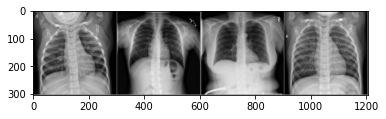

Ground Truth:  Normal Normal Normal Normal


In [33]:

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))

In [35]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch)))

Predicted:  Normal Normal Normal Normal


# Accuracy

In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 3776 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 3776 test images: 93 %


In [40]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of COVID : 97 %
Accuracy of Lung_Opacity : 83 %
Accuracy of Normal : 97 %
Accuracy of Viral Pneumonia : 91 %
